## Taking Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mp
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from chembl_webresource_client.new_client import new_client
import requests


Patchinbg for MORDERED to run


## Seaching for molecules that bind to target protien

In [29]:
target=new_client.target
target_query=target.search("ask1")
target_df=pd.DataFrame.from_dict(target_query)
target_df

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'Q99683', 'xref_name': None, 'xre...",Homo sapiens,Mitogen-activated protein kinase kinase kinase 5,15.0,False,CHEMBL5285,"[{'accession': 'Q99683', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Mus musculus,Mitogen-activated protein kinase kinase kinase 5,15.0,False,CHEMBL4879411,"[{'accession': 'O35099', 'component_descriptio...",SINGLE PROTEIN,10090


In [ ]:
target=target_df.target_chembl_id[0]
target

In [ ]:
activity=new_client.activity
res=activity.filter(target_chembl_id=target).filter(standard_type="IC50")
res_df=pd.DataFrame.from_dict(res)
res_df=res_df.drop_duplicates(subset="molecule_chembl_id").dropna(subset=["standard_value"])#dropping duplicate id and empty standard values
res_df

In [ ]:
res_df.iloc[9]

In [ ]:
res_df.to_csv("bioactivity_ASK1.csv")

Getting mol list on which we will work:

In [ ]:
ID_arr=res_df["molecule_chembl_id"].values
l=len(ID_arr)
ID_arr

Trying example of SMILE notation extraction

In [ ]:
molecule = new_client.molecule
SMILE = molecule.filter(chembl_id='CHEMBL471375').only(['molecule_structures'])[0]["molecule_structures"]["canonical_smiles"]
str(SMILE)


In [ ]:
SMILEarr=[]
for chembl_id in ID_arr:
    url = f'https://www.ebi.ac.uk/chembl/api/data/molecule/{chembl_id}.json'
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        smiles = data['molecule_structures']['canonical_smiles']
        print(f'ChEMBL ID: {chembl_id}, SMILES: {smiles}')
        SMILEarr.append(smiles)
    else:
        print(f'Error retrieving data for ChEMBL ID: {chembl_id}')

In [ ]:
from rdkit import Chem
from mordred import Calculator, descriptors

calc = Calculator(descriptors, ignore_3D=True)
mols = [Chem.MolFromSmiles(smi) for smi in SMILEarr]
df = calc.pandas(mols)

In [ ]:
df

In [23]:
arr=[]
activity=res_df["standard_value"].tolist()
for i in activity:
    i=float(i)
    if i<100:
        arr.append(1)
    else:
        arr.append(0)
df["label"]=arr

NameError: name 'res_df' is not defined

In [ ]:
df["label"].describe()

In [ ]:
sns.countplot(df,x="label",color="green")

In [ ]:
df.to_csv("ASK1datasheet.csv")

In [ ]:
df

## Welcome to model hell

In [4]:
df=pd.read_csv("ASK1datasheet.csv")

In [6]:
def replace_non_numeric_with_0(value):
    try:
        return float(value)
    except (ValueError, TypeError):
        return 0
df_cpy=df.applymap(replace_non_numeric_with_0)
df_cpy.fillna(0)

C:\Users\ghosh\AppData\Local\Temp\ipykernel_22928\1415429586.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cpy=df.applymap(replace_non_numeric_with_0)


,Unnamed: 0,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,label
0,0.0,16.946702,13.970524,0.0,0.0,28.121514,2.494273,4.802448,28.121514,1.339120,...,71.746870,274.110613,7.831732,885.0,34.0,118.0,144.0,5.638889,4.500000,0.0
1,1.0,29.156092,21.888974,0.0,1.0,47.715405,2.749242,5.270881,47.715405,1.363297,...,90.994468,466.200491,7.642631,2737.0,85.0,220.0,290.0,9.340278,7.347222,0.0
2,2.0,15.084601,13.504982,0.0,3.0,24.155652,2.486333,4.793549,24.155652,1.271350,...,68.767174,323.001787,11.137993,630.0,32.0,104.0,125.0,6.638889,4.055556,0.0
3,3.0,21.616419,16.544625,0.0,0.0,34.701568,2.440951,4.787564,34.701568,1.285243,...,78.030138,359.174610,7.482804,2104.0,40.0,148.0,174.0,8.451389,5.666667,1.0
4,4.0,20.868872,15.627043,0.0,0.0,33.633832,2.481213,4.869196,33.633832,1.293609,...,75.417265,343.168462,7.301457,1821.0,42.0,144.0,171.0,8.201389,5.444444,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,416.0,24.046279,17.846132,0.0,0.0,40.181263,2.500956,4.912045,40.181263,1.339375,...,80.406440,402.169191,7.734023,2506.0,55.0,166.0,201.0,8.222222,6.472222,0.0
417,417.0,24.781895,18.633638,0.0,0.0,41.302984,2.524477,4.941830,41.302984,1.332354,...,81.916468,480.079703,9.232302,2687.0,59.0,172.0,210.0,9.083333,6.694444,0.0
418,418.0,25.778330,18.874664,0.0,0.0,41.812602,2.501716,4.912834,41.812602,1.306644,...,82.889385,458.162391,7.899352,3072.0,59.0,180.0,217.0,10.034722,6.722222,0.0
419,419.0,21.965399,15.884860,0.0,0.0,35.892651,2.554920,5.006381,35.892651,1.329357,...,77.418461,374.120132,8.313781,1819.0,51.0,154.0,188.0,7.472222,5.694444,1.0


In [7]:
df_cpy.to_csv("checking.csv")
df_cpy_f=df_cpy.iloc[:,:-1]


In [21]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(df_cpy_f,df["label"], test_size=0.2, random_state=1651)

In [9]:
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
labelX=[]
labelY=[]
i=1
while i<=10:
    labelX.append(i)
    labelY.append(i+1)
    i=i+1
depth=0
while depth<15:
    depth=depth+1
    big_arr=[]
    split=1
    print(f"Predicting with parameter depth={depth}")
    while split<11:
        split=split+1
        arr=[]
        leaf=0
        while leaf<10:
            leaf=leaf+1
            clf = RandomForestClassifier(max_depth=depth, random_state=0, min_samples_split=split, min_samples_leaf=leaf,n_jobs=-1)
            kf = KFold(n_splits=10, shuffle=True, random_state=42)
            
            accuracies = []
            all_true_labels = []
            all_predicted_labels = []

            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                
                # Train the classifier and predict on the test set
                y_pred = clf.fit(X_train, y_train).predict(X_test)
                
                # Calculate accuracy for this fold
                accuracy = accuracy_score(y_test, y_pred)
                accuracies.append(accuracy)
            mean_accuracy = np.mean(accuracies)

            arr.append(mean_accuracy) 
        big_arr.append(arr) 
    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(data=big_arr,vmax=1,vmin=0.50,annot=True,xticklabels=labelX,yticklabels=labelY,ax=ax,cmap=sns.color_palette("hls", 100))
    ax.set_xlabel("leaf")
    ax.set_ylabel("split")
    ax.set_title("depth="+str(depth))
    fig.savefig(str(depth))    
      
            


Predicting with parameter depth=1


KeyboardInterrupt: 

In [22]:
clf = RandomForestClassifier(max_depth=8, random_state=1651, min_samples_split=6, min_samples_leaf=2,n_jobs=-1)
clf.fit(X,y)
clf.score(X_test,y_test)

0.8

In [ ]:
clf.score(df_cpy_f,df["label"])

In [27]:
i=0
scores=[]
while i<1000:
    X, X_test, y, y_test = train_test_split(df_cpy_f,df["label"], test_size=0.2, random_state=i)
    clf = RandomForestClassifier(max_depth=8, random_state=i, min_samples_split=6, min_samples_leaf=2,n_jobs=-1)
    clf.fit(X,y)
    scores.append(clf.score(X_test,y_test))
    i=i+1


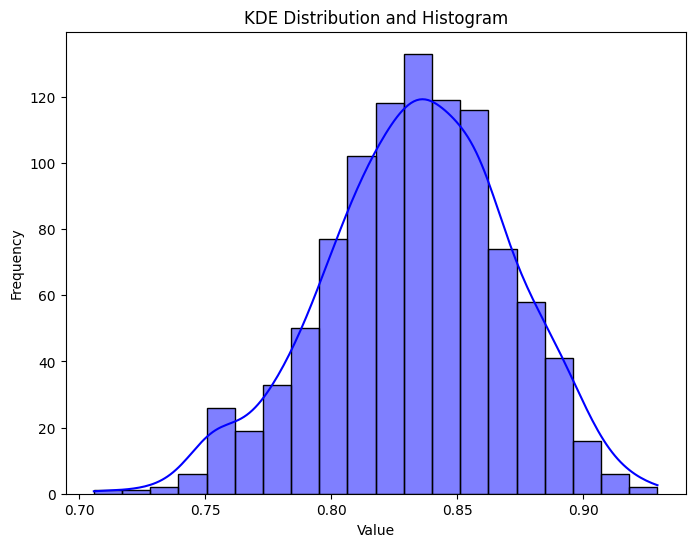

In [28]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot KDE distribution and histogram on the same plot
sns.histplot(scores, kde=True, color='blue', ax=ax, bins=20)

ax.set_title("KDE Distribution and Histogram")
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")

plt.show()

# Going For the kill: Using a deepL model

In [54]:
df=pd.read_csv("ASK1datasheet.csv")


df_cpy=df.applymap(replace_non_numeric_with_0)
df_cpy.fillna(0)

df_cpy.to_csv("checking.csv")
df_cpy_f=df_cpy.iloc[:,:-1]

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_cpy_f = pd.DataFrame(scaler.fit_transform(df_cpy_f), columns=df_cpy_f.columns)



from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(df_cpy_f,df["label"], test_size=0.2, random_state=42)

C:\Users\ghosh\AppData\Local\Temp\ipykernel_19176\110646342.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cpy=df.applymap(replace_non_numeric_with_0)


In [55]:
def schedule(epoch,lr):
    print("Epochs Processed="+str(epoch))
    if epoch<5:
        return 0.001
    if epoch<10:
        return 0.0001
    return 0.00001
schedule_callback=keras.callbacks.LearningRateScheduler(schedule)

early_stopper_callback=keras.callbacks.EarlyStopping(monitor="val_loss",
                                                   patience=3,
                                                   restore_best_weights=True)


In [1]:
X, X_CV, y, y_CV = train_test_split(X,y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [57]:
X

,Unnamed: 0,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
83,0.197619,0.309987,0.282480,0.0,0.000000,0.522842,0.885383,0.900230,0.522842,0.922751,...,0.393471,0.432533,0.360310,0.641805,2.660933e-08,0.260870,0.305263,0.301802,0.285332,0.309413
200,0.476190,0.177141,0.097722,0.0,0.000000,0.425848,0.859164,0.896264,0.425848,0.960337,...,0.254373,0.027066,0.105137,0.249962,1.159705e-08,0.130435,0.168421,0.157658,0.087383,0.164026
99,0.235714,0.631567,0.599764,0.0,0.000000,0.784224,0.937206,0.944853,0.784224,0.936273,...,0.729798,0.742586,0.538036,0.384671,7.422604e-08,0.637681,0.663158,0.702703,0.504681,0.622554
149,0.354762,0.386619,0.354038,0.0,0.000000,0.584865,0.896109,0.918054,0.584865,0.913112,...,0.539077,0.511408,0.347917,0.193660,4.085995e-08,0.391304,0.400000,0.409910,0.417744,0.404473
389,0.926190,0.405072,0.429040,0.0,0.000000,0.607485,0.880241,0.904419,0.607485,0.913299,...,0.460912,0.555879,0.344387,0.143802,4.412776e-08,0.347826,0.400000,0.400901,0.388765,0.458527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.202381,0.250584,0.242233,0.0,0.333333,0.482182,0.908040,0.930543,0.482182,0.932038,...,0.403795,0.383151,0.186722,0.136742,1.761671e-08,0.246377,0.252632,0.261261,0.213999,0.268406
351,0.835714,0.511805,0.478147,0.0,0.000000,0.675176,0.893058,0.909434,0.675176,0.913560,...,0.571684,0.632685,0.402359,0.166545,6.140048e-08,0.434783,0.515789,0.522523,0.419082,0.506990
147,0.350000,0.367159,0.329962,0.0,0.000000,0.553537,0.896043,0.916260,0.553537,0.898770,...,0.516808,0.488185,0.282817,0.050535,3.592137e-08,0.347826,0.378947,0.382883,0.401694,0.354147
53,0.126190,0.465487,0.463839,1.0,0.000000,0.639975,0.897524,0.907054,0.639975,0.895791,...,0.517365,0.607883,0.452848,0.359522,5.648648e-08,0.405797,0.463158,0.463964,0.499331,0.495806


In [58]:
nodes=[8,16,32,64,128,192,256,384,512]
layers=[1,2,3,4,5,6,7,8,9,10]
arr=np.empty((9,10))
i=0
while i<9:
    j=0
    while j<9:
        print("Iteration for "+str(i)+" "+str(j))
        keras.backend.clear_session()
        inputs=keras.Input((1614,))
        x=keras.layers.Dense(i,activation="swish")(inputs)
        c=0
        while(c<layers[j]-1):
            x=keras.layers.Dense(i,activation="swish")(x)
            c=c+1
        outputs=keras.layers.Dense(1,activation="sigmoid")(x)
        model=keras.Model(inputs=inputs, outputs=outputs,name="MNISTbasic_"+str(i)+"_"+str(j))
        model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(),#lr=0.0001),
              metrics=[keras.metrics.categorical_accuracy])
        model.fit(x=X,y=y,epochs=30,batch_size=125,validation_split=0.2,verbose=False)
        arr[i][j]=model.evaluate(x=X_CV,y=y_CV,verbose=False)[1]
        j=j+1
    i=i+1
print("Array Made")

Iteration for 0 0
Iteration for 0 1
Iteration for 0 2
Iteration for 0 3
Iteration for 0 4
Iteration for 0 5
Iteration for 0 6
Iteration for 0 7
Iteration for 0 8
Iteration for 1 0
Iteration for 1 1
Iteration for 1 2
Iteration for 1 3
Iteration for 1 4
Iteration for 1 5
Iteration for 1 6
Iteration for 1 7
Iteration for 1 8
Iteration for 2 0
Iteration for 2 1
Iteration for 2 2
Iteration for 2 3
Iteration for 2 4
Iteration for 2 5
Iteration for 2 6
Iteration for 2 7
Iteration for 2 8
Iteration for 3 0
Iteration for 3 1
Iteration for 3 2
Iteration for 3 3
Iteration for 3 4
Iteration for 3 5
Iteration for 3 6
Iteration for 3 7
Iteration for 3 8
Iteration for 4 0
Iteration for 4 1
Iteration for 4 2
Iteration for 4 3
Iteration for 4 4
Iteration for 4 5
Iteration for 4 6
Iteration for 4 7
Iteration for 4 8
Iteration for 5 0
Iteration for 5 1
Iteration for 5 2
Iteration for 5 3
Iteration for 5 4
Iteration for 5 5
Iteration for 5 6
Iteration for 5 7
Iteration for 5 8
Iteration for 6 0
Iteration 

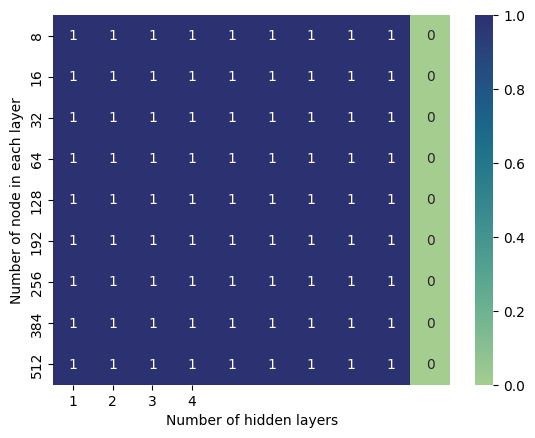

In [59]:
layers=[1,2,3,4]
s=sns.heatmap(arr,annot=True,vmin=0,vmax=1,yticklabels=nodes,xticklabels=layers,cmap="crest")
s.set_xlabel("Number of hidden layers")
s.set_ylabel("Number of node in each layer")
s.figure.savefig("Hyptest.png")